In [1]:
import setigen as stg
import bifrost as bf
from bifrost.fdmt import Fdmt
import numpy as np
import blimpy as bl
import cupy as cp
import matplotlib.pyplot as plt
from astropy import units as u

import hyperseti
from hyperseti import dedoppler
from hyperseti import plotting 

from timeit import default_timer as timer
%matplotlib inline

fdmt= Fdmt()

/home/cho134/.local/lib/python3.9/site-packages/cupy/_environment.py:434: UserWarning: 
--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy, cupy-cuda110

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate CuPy package.
       Refer to the Installation Guide for detailed instructions.

         https://docs.cupy.dev/en/stable/install.html

--------------------------------------------------------------------------------

  warnings.warn(f'''


In [2]:
def frame1():
    frame = stg.Frame(fchans=1024*u.pixel,
                      tchans=20*u.pixel,
                      df=1*u.Hz,
                      dt=10*u.s,
                      fch1=6095*u.MHz)
    noise = frame.add_noise(x_mean=10, noise_type='chi2')
    signal = frame.add_signal(stg.constant_path(f_start=frame.get_frequency(index=frame.fchans/2),
                                                drift_rate=-(frame.df/frame.dt)),
                              stg.constant_t_profile(level=frame.get_intensity(snr=30)),
                              stg.box_f_profile(width=1*u.Hz),
                              stg.constant_bp_profile(level=1))
    return frame

In [3]:
def framegen(fchans,tchans,df,dt,fch1):
    frame = stg.Frame(fchans=fchans*u.pixel,
                      tchans=tchans*u.pixel,
                      df=df*u.Hz,
                      dt=dt*u.s,
                      fch1=fch1*u.MHz)
    noise = frame.add_noise(x_mean=10, noise_type='chi2')
    signal = frame.add_signal(stg.constant_path(f_start=frame.get_frequency(index=frame.fchans/2),
                                                drift_rate=frame.df/frame.dt),
                              stg.constant_t_profile(level=frame.get_intensity(snr=30)),
                              stg.box_f_profile(width=1*u.Hz),
                              stg.constant_bp_profile(level=1))
    return frame

In [4]:
def ddframecenteredtwice(stgframe, gulp_size, exponent):
    fr=stgframe
    drift_rate=fr.df/fr.dt
    frequency = fr.dt*fr.tchans*drift_rate
    max_delay=int(frequency*2)

    gulp_size = gulp_size

    d_cpu = np.expand_dims(fr.data, axis=0)
    #print(d_cpu.shape)

    ## Initialize FDMT
    n_disp = max_delay
    n_time = d_cpu.shape[2]
    n_chan = d_cpu.shape[1]
    fdmt.init(n_chan, n_disp, fr.fch1, fr.df, space="cuda", exponent=exponent)


    # Input shape is (1, n_freq, n_time)
    d_in = bf.ndarray(d_cpu, dtype='f32', space='cuda')
    d_out = bf.ndarray(np.zeros(shape=(1, n_disp, n_time)), dtype='f32', space='cuda')

    # Execute FDMT
    #start = timer()

    fdmt.execute(d_in, d_out, negative_delays=True)
    #end = timer()
    #time=end-start
    #timesFDMT.append(time)
    
    d_out = d_out.copy(space='system')

    img = cp.asarray(d_out.squeeze())
    peaks, xvals, yvals = hyperseti.peak.prominent_peaks(img, num_peaks=1, min_xdistance=100, min_ydistance=100, threshold=100)
    print(peaks)    
    
    #d_out2 = d_out2.copy(space='system')
    plt.figure(figsize=(9, 6))
    plt.imshow(np.log(np.array(d_out).squeeze()), aspect='auto', extent=[0, fr.fchans, ((max_delay/fr.tchans)*(fr.df/fr.dt)), 0])
    #, extent=[0, 1024, 0.23, 0]
    plt.xlabel("Frequency")
    plt.ylabel("Dispersion trial")
    plt.colorbar()

[499.21686]


/tmp/ipykernel_2904/3485438698.py:39: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.array(d_out).squeeze()), aspect='auto', extent=[0, fr.fchans, ((max_delay/fr.tchans)*(fr.df/fr.dt)), 0])


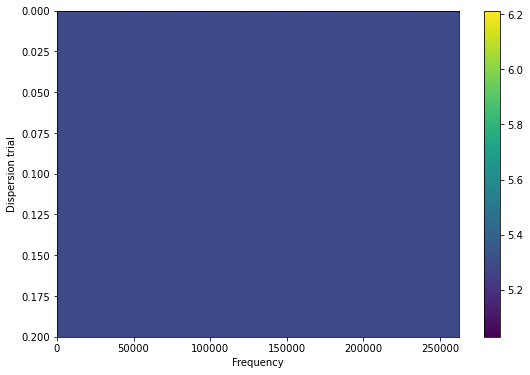

In [5]:
frame2=framegen(2**18,20,1,10,6095)
ddframecenteredtwice(frame2, 4*80000, 1)

In [6]:
def ddframecentered(stgframe, negative_delays, exponent):
    
    fr=stgframe
    drift_rate=fr.df/fr.dt
    frequency = fr.dt*fr.tchans*drift_rate
    max_delay=int(frequency*2)
    print(max_delay)
    #max_delay = max_drift_rate
    gulp_size = 4 * 8192

    d_cpu = np.expand_dims(fr.data, axis=0)
    print(d_cpu.shape)

    ## Initialize FDMT
    n_disp = max_delay
    n_time = d_cpu.shape[2]
    n_chan = d_cpu.shape[1]
    fdmt.init(n_chan, n_disp, fr.fch1, fr.df, space="cuda", exponent=exponent)


    # Input shape is (1, n_freq, n_time)
    d_in = bf.ndarray(d_cpu, dtype='f32', space='cuda')
    d_out = bf.ndarray(np.zeros(shape=(1, n_disp, n_time)), dtype='f32', space='cuda')

    # Execute FDMT
    fdmt.execute(d_in, d_out, negative_delays=negative_delays)

    d_out = d_out.copy(space='system')
    
    img = cp.asarray(d_out.squeeze())
    peaks, xvals, yvals = hyperseti.peak.prominent_peaks(img, num_peaks=1, min_xdistance=100, min_ydistance=100, threshold=100)
    print(peaks)  
    
    #plotting the fdmt
    plt.figure(figsize=(9, 6))
    plt.imshow(np.log(np.array(d_out).squeeze()), aspect='auto', extent=[0, fr.fchans, ((max_delay/fr.tchans)*(fr.df/fr.dt)), 0])
    #, extent=[0, 1024, 0.23, 0]
    plt.xlabel("Frequency")
    plt.ylabel("Dispersion trial")
    plt.colorbar()
    

[249.87787]


/tmp/ipykernel_2904/3485438698.py:39: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.array(d_out).squeeze()), aspect='auto', extent=[0, fr.fchans, ((max_delay/fr.tchans)*(fr.df/fr.dt)), 0])


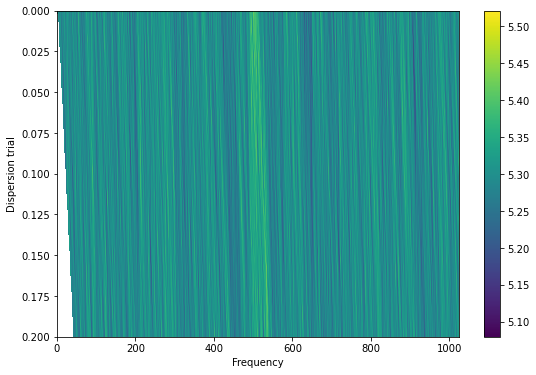

In [7]:
ddframecenteredtwice(frame1(), 2, 1)

40
(1, 20, 1024)
[495.32922]


/tmp/ipykernel_2904/3463881091.py:36: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.array(d_out).squeeze()), aspect='auto', extent=[0, fr.fchans, ((max_delay/fr.tchans)*(fr.df/fr.dt)), 0])


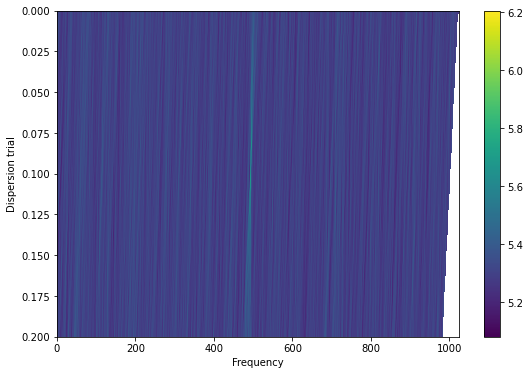

In [8]:
ddframecentered(frame1(), False, 1)

40
(1, 20, 262144)
[262.2892]


/tmp/ipykernel_2904/3463881091.py:36: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.array(d_out).squeeze()), aspect='auto', extent=[0, fr.fchans, ((max_delay/fr.tchans)*(fr.df/fr.dt)), 0])


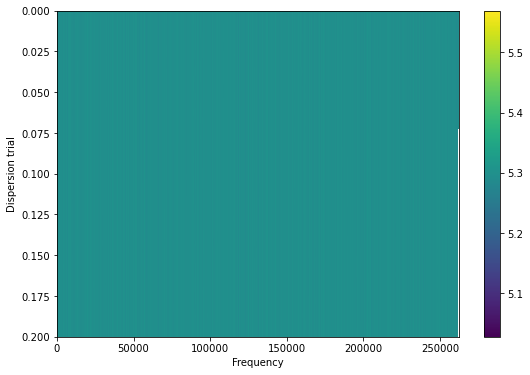

In [9]:
ddframecentered(frame2, False, 1)